# Машинное обучение, ФКН ВШЭ

# Практическое задание 10. Обучение без учителя.

## Общая информация
Дата выдачи: 23.03.2022

Мягкий дедлайн: 06.04.2022 23:59 MSK

Жёсткий дедлайн: 10.04.2022 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-10-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании мы посмотрим на несколько алгоритмов кластеризации и применим их к географическим и текстовым данным. Также мы подробно остановимся на тематическом моделировании текстов, задаче обучения представлений и в каком-то смысле поработаем с semi-supervised learning. 



In [2]:
import pandas as pd
import numpy as np

np.random.seed(0xFFFFFFF)

**Задание 0 (1e-100 балла)**. Опишите свои ощущения от домашки по ЕМ-алгоритму (можно картинкой или мемом).

In [3]:
# YOUR CODE HERE (ノಠ益ಠ)ノ彡┻━┻

## Часть 1. Кластеризация автобусных остановок

В этом задании мы сравним разные алгоритмы кластеризации для данных об автобусных остановках Москвы.

**Задание 1.1 (1 балл).** Реализуйте алгоритм спектральной кластеризации, который упоминался на лекции. Для этого разберитесь с кодом шаблона, данного ниже, и допишите недостающую функцию. Напомним, что для графа с матрицей смежности $W = \{w_{ij}\}_{i, j = 1 \dots \ell}$ лапласиан определяется как:

$$
L = D - W,
$$

где $D = \text{diag}(d_1, ..., d_{\ell}), d_i = \sum_{j=1}^{\ell} w_{ij}$.

In [4]:
from sklearn.base import ClusterMixin
from sklearn.cluster import KMeans, DBSCAN


class GraphClustering(ClusterMixin):
    def __init__(self, n_clusters=8, n_components=None, **kwargs):
        '''
        Spectral clustering algorithm
        param n_clusters: number of clusters to form
        param n_components: number of eigenvectors to use
        '''

        if n_components is None:
            n_components = n_clusters

        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, **kwargs)

    def fit_predict(self, X, y=None):
        '''
        Perform spectral clustering from graph adjacency matrix
        and return vertex labels.
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, ) - vertex labels
        '''
        eigenvectors = self._generate_eigenvectors(X)
        labels = self.kmeans.fit_predict(eigenvectors[:, 1:])
        return labels

    def _generate_eigenvectors(self, X):
        '''
        Compute eigenvectors for spectral clustering
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, n_components) - eigenvectors
        '''
        L = np.diag(X.sum(axis=0)) - X
        w, v = np.linalg.eigh(L)
        sorted_eig_args = np.argsort(w)
        return v[:, sorted_eig_args[:self.n_components]]

Перед тем, как переходить к следующему заданию, протестируйте свое решение.

In [5]:
n_blocks, n_vertices = 10, 1000
block_vertices = n_vertices // n_blocks

X = np.zeros((n_vertices, n_vertices))
for i in range(0, n_vertices, block_vertices):
    X[i:i + block_vertices, i:i + block_vertices] = np.sqrt(i + 1)

graph_clustering = GraphClustering(n_clusters=n_blocks)
labels = graph_clustering.fit_predict(X)

true_labels = np.zeros(n_vertices, dtype=np.int32)
for i in range(0, n_vertices, block_vertices):
    true_labels[i:i + block_vertices] = labels[i]

assert labels.shape == (n_vertices, )
assert np.all(np.bincount(labels) == np.full(n_blocks, block_vertices))
assert np.all(labels == true_labels)

Теперь можем приступить к работе с реальными данными. Скачайте файл с данными об остановках общественного транспорта **в формате .xlsx** по [ссылке](https://data.mos.ru/opendata/download/60464/1/201) (так гарантированно не возникнет проблем с парсингом файла) и загрузите таблицу в ноутбук. Если вдруг сайт Правительства Москвы сойдет с ума, то возьмите какую-нибудь версию данных [отсюда](https://data.mos.ru/opendata/7704786030-city-surface-public-transport-stops). Для удобства визуализации мы будем работать только с остановками в ЦАО.

In [7]:
data = pd.read_excel('transport.xlsx')
data = data[data.AdmArea_en == "Czentral`ny'j administrativny'j okrug"]
data = data.reset_index()
data.head()

index  ID_en                                            Name_en  \
0    278    347       «2-й Лесной пер.», улица Бутырский Вал (347)   
1    279    349    «Ул. Сущевский Вал», Новослободская улица (349)   
2    355    479  «Стадион Лужники (южн.) (пос.)», улица Лужники...   
3    356    480      «Спортзал Дружба», Лужнецкая набережная (480)   
4    357    481       «Лужнецкая наб.», Лужнецкая набережная (481)   

   Longitude_WGS84_en  Latitude_WGS84_en             Street_en  \
0           37.586584          55.782106   улица Бутырский Вал   
1           37.590714          55.790630  Новослободская улица   
2           37.565972          55.714265         улица Лужники   
3           37.570191          55.712504  Лужнецкая набережная   
4           37.574559          55.713770  Лужнецкая набережная   

                              AdmArea_en      District_en  \
0  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
1  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
2  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
3  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
4  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   

                          RouteNumbers_en                 StationName_en  \
0                   АТ18; А12; АТ56; АТ78                2-й Лесной пер.   
1             АТ47; АМ10; АТ3; АТ56; АТ78              Ул. Сущевский Вал   
2  А64; А216; А809; АС12; А255; АБК; АТ79  Стадион Лужники (южн.) (пос.)   
3  А64; А216; А809; АС12; А255; АБК; АТ79                Спортзал Дружба   
4  А64; А216; А809; АС12; А255; АБК; АТ79                 Лужнецкая наб.   

   Direction_en Pavilion_en OperatingOrgName_en EntryState_en  global_id  \
0           NaN          да   ГУП «Мосгортранс»        active  889085436   
1           NaN          да   ГУП «Мосгортранс»        active  889085437   
2           NaN          да   ГУП «Мосгортранс»        active  889085549   
3           NaN          да   ГУП «Мосгортранс»        active  889085550   
4           NaN          да   ГУП «Мосгортранс»        active  889085551   

   geoData  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

Воспользуемся библиотекой `folium` для визуализации данных.

In [8]:
import folium

map = folium.Map([55.75215, 37.61819], zoom_start=12)
for id, row in data.iterrows():
    folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                  radius=10).add_to(map)
map

**Задание 1.2 (1 балл).** Попробуем построить граф, в котором вершинами будут остановки. Как вы уже могли заметить, для каждой остановки указаны номера маршрутов, проходящих через неё. Логично соединить ребрами соседние остановки каждого маршрута. Однако мы не знаем, в каком порядке автобусы объезжают остановки. Но мы можем применить эвристический алгоритм, который восстановит нам порядок маршрутов:

* Для каждого маршрута выделим список всех остановок, через которые он проходит.
* Выберем начальную остановку маршрута как точку, наиболее удаленную от всех остальных остановок этого маршрута.
* Каждую следующую точку маршрута будем выбирать как самую близкую из оставшихся точек (не включенных в маршрут ранее).

Фактически, у нас получается жадное решение задачи коммивояжера. Когда мы отсортировали маршруты, можем построить по ним граф. Будем строить его по таким правилам:

* Между двумя остановками будет ребро, если они являются соседними хотя бы на одном маршруте. Вес ребра равен числу маршрутов, на которых остановки являются соседними.
* В графе не будет петель (то есть у матрицы смежности будет нулевая диагональ).

Реализуйте предложенный способ построения графа. Для этого рекомендуется воспользоваться шаблонами, приведенными ниже.

In [9]:
ROUTE_NUMBERS = 'RouteNumbers_en'
ID = 'ID_en'
LAT = 'Latitude_WGS84_en'
LONG = 'Longitude_WGS84_en'

def get_routes(data):
    '''
    Accumulate routes from raw data
    param data: pd.DataFrame - public transport stops data
    return: dict - unsorted stops ids for each route,
                   e.g. routes['A1'] = [356, 641, 190]
    '''
    routes = {}
    for row in data.iterrows():
        busses = row[1][ROUTE_NUMBERS].split('; ')
        for buss in busses:
            if buss not in routes:
                routes[buss] = []
            routes[buss] += [row[1][ID]]
    return routes


def get_distances_to_point(data, id):
    long = float(data[data[ID] == id][LONG])
    lat = float(data[data[ID] == id][LAT])
    return np.sqrt((long - data[LONG]) ** 2 + (lat - data[LAT]) ** 2).to_numpy()


def get_distance_matrix(data):
    proxy_ids = {}
    matrix = np.zeros((data.shape[0], data.shape[0]))
    for i, row in enumerate(data.iterrows()):
        proxy_ids[i] = row[1][ID]
        matrix[i] = get_distances_to_point(data, row[1][ID])
    return matrix, proxy_ids


def get_idx_farest_point(distances):
    return np.where(distances.sum(axis=0) == distances.sum(axis=0).max())[0][0]


def get_closest_point_except(distances, idx, idxs_except):
    mask = np.ones(distances.shape[0], dtype=bool)
    mask[idxs_except] = False
    res = distances[idx] == distances[idx, mask].min()
    res[idxs_except] = False
    return np.where(res)[0][0]


def sort_routes(data, routes):
    '''
    Sort routes according to the proposed algorithm
    param data: pd.DataFrame - public transport stops data
    param routes: dict - unsorted stops ids for each route
    return: dict - sorted stops ids for each route
    '''
    sorted_routes = {}
    for route_name, route_list in routes.items():
        route_stations = data[data[ID].isin(route_list)]
        distance_matrix, proxy_to_id = get_distance_matrix(route_stations)
        idx = get_idx_farest_point(distance_matrix)
        idx_in_data = data.index[data[ID] == proxy_to_id[idx]].tolist()[0]
        already_in_road = [idx]
        sorted_routes[route_name] = [idx_in_data]
        while len(already_in_road) < distance_matrix.shape[0]:
            idx = get_closest_point_except(
                distance_matrix, idx, already_in_road)
            idx_in_data = data.index[data[ID] == proxy_to_id[idx]].tolist()[0]
            already_in_road += [idx]
            sorted_routes[route_name] += [idx_in_data]
    return sorted_routes


def get_adjacency_matrix(data, sorted_routes):
    '''
    Compute adjacency matrix for sorted routes
    param data: pd.DataFrame - public transport stops data
    param sorted_routes: dict - sorted stops ids for each route
    return: (n_samples, n_samples) - graph adjacency matrix
    '''
    adjacency_matrix = np.zeros((data.shape[0], data.shape[0]))
    for _, route in sorted_routes.items():
        for i in range(1, len(route)):
            adjacency_matrix[route[i - 1]][route[i]] = 1
            adjacency_matrix[route[i]][route[i - 1]] = 1
    return adjacency_matrix

In [10]:
routes = get_routes(data)
sorted_routes = sort_routes(data, routes)
adjacency_matrix = get_adjacency_matrix(data, sorted_routes)

Проверим, что маршруты получились адекватными. Для этого нарисуем их на карте.

In [11]:
map = folium.Map([55.75215, 37.61819], zoom_start=12)
for route_id in np.random.choice(list(sorted_routes.keys()), size=5):
    coords = data.loc[
        sorted_routes[route_id],
        ['Latitude_WGS84_en', 'Longitude_WGS84_en']
    ].values.tolist()
    folium.vector_layers.PolyLine(coords).add_to(map)

map

**Задание 1.3 (0 баллов)**. Реализуйте функцию `draw_clustered_map`, которая рисует карту центра Москвы с кластерами остановок, раскрашенными в разные цвета.

In [12]:
COLORS = [
    'red', 'blue', 'green', 'purple', 'orange', 'darkred', 'darkblue',
    'darkgreen', 'cadetblue', 'darkpurple', 'gray', 'black'
]

def draw_clustered_map(data, labels):
    '''
    Create map with coloured clusters
    param data: pd.DataFrame - public transport stops data
    param labels: (n_samples, ) - cluster labels for each stop
    return: folium.Map - map with coloured clusters
    '''
    map = folium.Map([55.75215, 37.61819], zoom_start=12)
    for id, row in data.iterrows():
      color = COLORS[labels[id] % len(COLORS)]
      folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                  radius=10, color = color).add_to(map)
    return map

**Задание 1.4 (1.5 балла)**. Примените алгоритмы кластеризации K-Means и DBSCAN из `sklearn` на координатах остановок, а также свою реализацию спектральной кластеризации на построенной выше матрице смежности. Визуализируйте результат кластеризации с помощью функции `draw_clustered_map`. Подберите параметры алгоритмов (`n_clusters` у K-Means, `eps` у DBSCAN, `n_clusters` и `n_components` у спектральной кластеризации) так, чтобы получить наиболее характерный для этих алгоритмов результат кластеризации (можете поэкспериментировать и оставить в ноутбуке картинки только для итоговых значений параметров, также обратите внимание на баланс объектов в кластерах). Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [13]:
draw_clustered_map(data, GraphClustering(n_clusters=15, n_components=8).fit_predict(adjacency_matrix))

In [14]:
draw_clustered_map(data, KMeans(n_clusters=13).fit_predict(data[[LAT, LONG]]))

In [15]:
draw_clustered_map(data, DBSCAN(eps=0.0044).fit_predict(data[[LAT, LONG]]))

Проинтерпретируйте полученные результаты. Чем отличаются разбиения на кластеры, получаемые разными алгоритмами? Какие плюсы и минусы есть у каждого алгоритма? Какой алгоритм кажется вам наиболее подходящим для кластеризации остановок?

**Ответ:**
* Наш алгоритм выдаёт связь основываясь на максимальное количество возможностей доехать на автобусе.
* Также наш алгоритм мог бы и рабоатать на матрице расстояний, скорее всего в этом случае получилось бы похоже на K-Means.
* K-Means и DBSCAN основываются строго на расстоянии.
* DBSCAN относит довольно много точек к выбросам или почти все к 1 классу в зависимости от eps.

## Часть 2. Тематическое моделирование текстов

В этой части мы познакомимся с одной из самых популярных задач обучения без учителя &mdash; с задачей тематического моделирования текстов. Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. Фактически, мы будем решать задачу, похожую на кластеризацию текстов: отличие в том, что нас будет интересовать не только разбиение текстов на группы, но и выделение ключевых слов, определяющих каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [16]:
data = pd.read_csv('bbc-news-data.csv', sep='\t')
data.sample(5)

category filename                              title  \
17         business  018.txt  India's rupee hits five-year high   
185        business  186.txt   Huge rush for Jet Airways shares   
1668          sport  356.txt   Dawson joins England injury list   
1197       politics  302.txt   Galloway targets 'New Labour' MP   
822   entertainment  313.txt    BBC to pour £9m into new comedy   

                                                content  
17     India's rupee has hit a five-year high after ...  
185    Indian airline Jet Airways' initial public of...  
1668   Scrum-half Matt Dawson is an injury doubt for...  
1197   George Galloway is to stand against pro-Iraq ...  
822    The BBC is to invest £9m in developing new co...

Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой части мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [18]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /home/panesher/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/panesher/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/panesher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [20]:
data['raw_text'] = data.apply(lambda row: row.title + row.content, axis=1)
data['text'] = data.apply(lambda row: preprocess(row.raw_text), axis=1)

Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [25]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

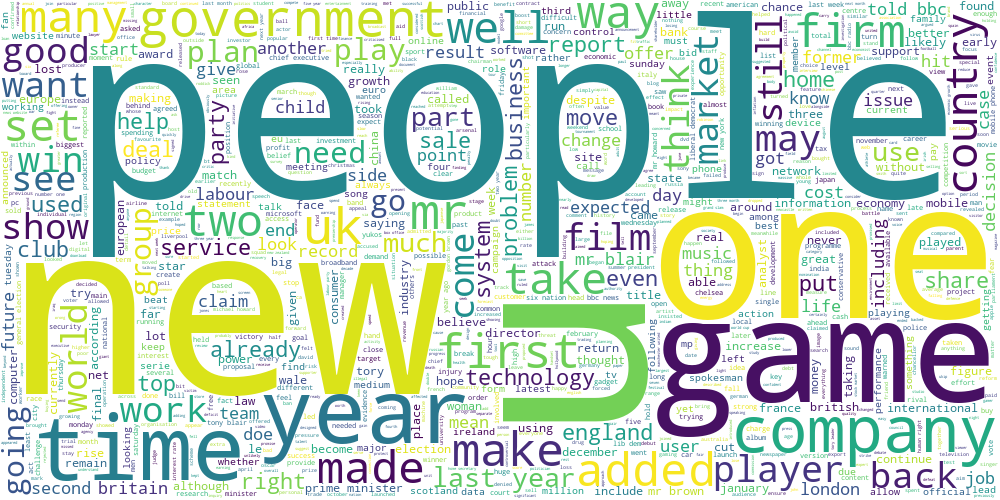

In [26]:
draw_wordcloud(data.text)

**Задание 2.1 (1 балл).** Обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении tf-idf векторайзера рекомендуется отбрасывать редко встречающиеся слова, а также воздержитесь от использования N-грамм. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров. Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.

**Ответ:** В целом интерпритируемо 0 про футбол, 1 про фильмы, 2 про экономику и тд (не стал оставлять все).

In [147]:
from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(107)
vect = TfidfVectorizer(min_df=15)
X = vect.fit_transform(data.text)
kmeans = KMeans()
labels = kmeans.fit_predict(X)

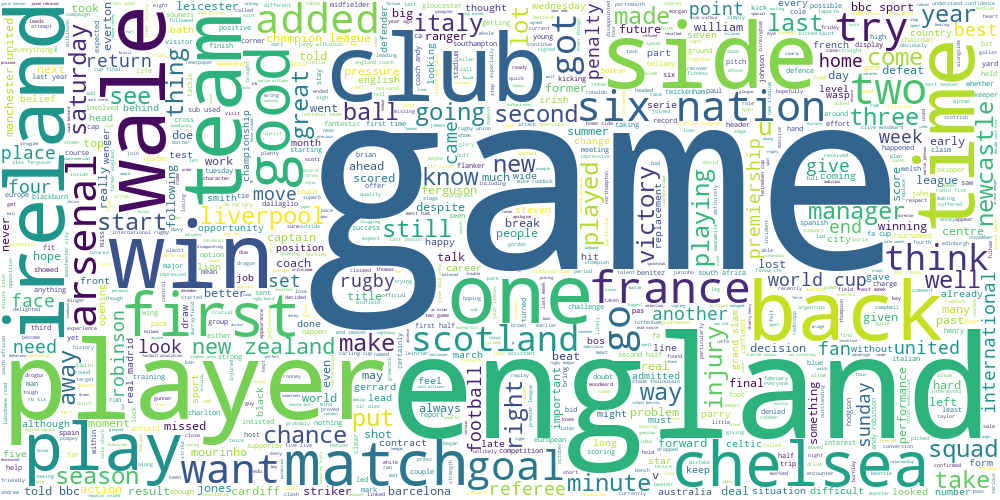

In [148]:
draw_wordcloud(data.text[labels == 0])

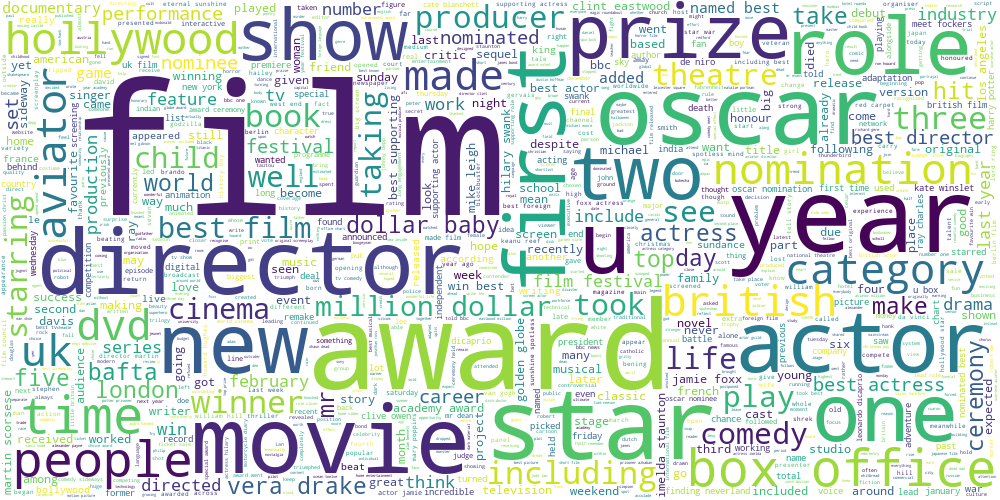

In [149]:
draw_wordcloud(data.text[labels == 1])

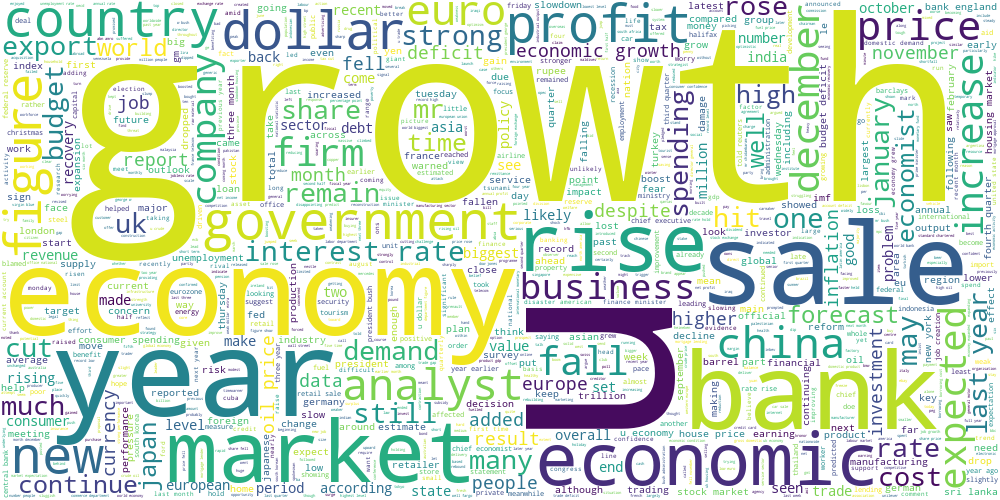

In [150]:
draw_wordcloud(data.text[labels == 2])

**Задание 2.2 (0.5 балла).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на слова, для которых значения соответствующих им признаков максимальны. Согласуются ли полученные слова с облаками тегов из прошлого задания?

**Ответ:**

In [227]:
for i in range(8):
    center_i = kmeans.cluster_centers_[i]
    t = np.zeros(center_i.shape)
    t[center_i > np.quantile(center_i, 0.999)] = 1
    print('Main words for cluster', i, *vect.inverse_transform([t]))

Main words for cluster 0 ['club' 'england' 'game' 'player']
Main words for cluster 1 ['actor' 'award' 'best' 'film']
Main words for cluster 2 ['economy' 'growth' 'price' 'rate']
Main words for cluster 3 ['album' 'band' 'music' 'show']
Main words for cluster 4 ['champion' 'open' 'seed' 'world']
Main words for cluster 5 ['mobile' 'people' 'phone' 'technology']
Main words for cluster 6 ['company' 'firm' 'government' 'mr']
Main words for cluster 7 ['election' 'labour' 'mr' 'party']


**Задание 2.3 (1.5 балла).** В первой части мы сравнили три разных алгоритма кластеризации на географических данных. Проделаем то же самое для текстовых данных (в качестве признакого описания снова используем tf-idf). Получите три разбиения на кластеры с помощью алгоритмов K-Means, DBSCAN и спектральной кластеризации (на этот раз воспользуйтесь реализацией из `sklearn`). Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров.

Далее, обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [289]:
from sklearn.cluster import SpectralClustering
labels_kmeans = KMeans().fit_predict(X)
labels_spec = SpectralClustering().fit_predict(X)
labels_dbscan = DBSCAN(eps=.86).fit_predict(X)

In [290]:
lebels_map = {
    'KMeans': labels_kmeans,
    'SpectralClustering': labels_spec,
    'DBSCAN': labels_dbscan
}

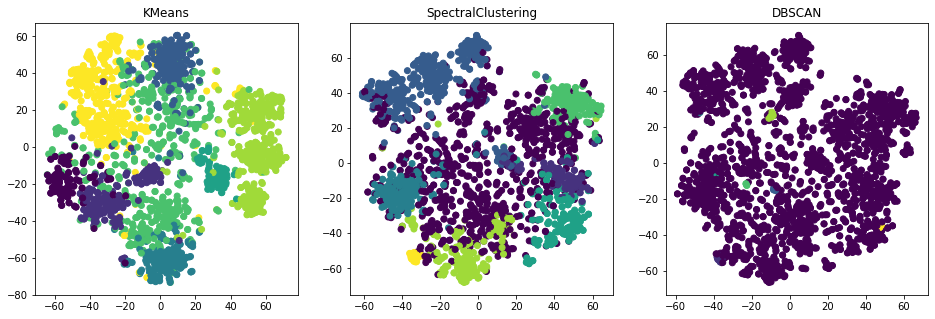

In [291]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
_, axs = plt.subplots(1, 3, figsize=(16, 5))
for i, (name, labels) in enumerate(lebels_map.items()):
    X_embedded = TSNE(n_components=2).fit_transform(X, labels)
    plt.sca(axs[i])
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels)
    plt.title(name)

Прокомментируйте получившиеся результаты. Какой баланс кластеров получился у разных методов? Соотносятся ли визуализации для текстов с визуализациями для географических данных?

**Ответ:**
* DBSCAN показал худжий баланс классов, отнеся почти всё в коробку с выбросами.
* Похоже, что KMeans сработал получше, чем спектральная класстеризация

**Задание 2.4 (1.5 балла).** Обучите модель латентного размещения Дирихле. Не забудьте, что она работает с мешком слов, а не с tf-idf признаками. Придумайте, как превратить распределение тем для текста в номер его кластера. Возьмите параметр `n_components` в 2-3 раза больше, чем число кластеров для K-Means. Получились ли темы более узкими от такого нововведения? Постройте облака тегов для нескольких наиболее удачных тем.

**Ответ:** Да, кажется удалось построить более углублённую классификацию. Так удалось отделить статьи о ТВ программах от футбольных игр и фильмовых наград. 

In [310]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
np.random.seed(107)
bag_of_words = CountVectorizer().fit_transform(data.text)
labels_lda = np.argmax(
    LatentDirichletAllocation(n_components=16).fit_transform(bag_of_words), axis=1)

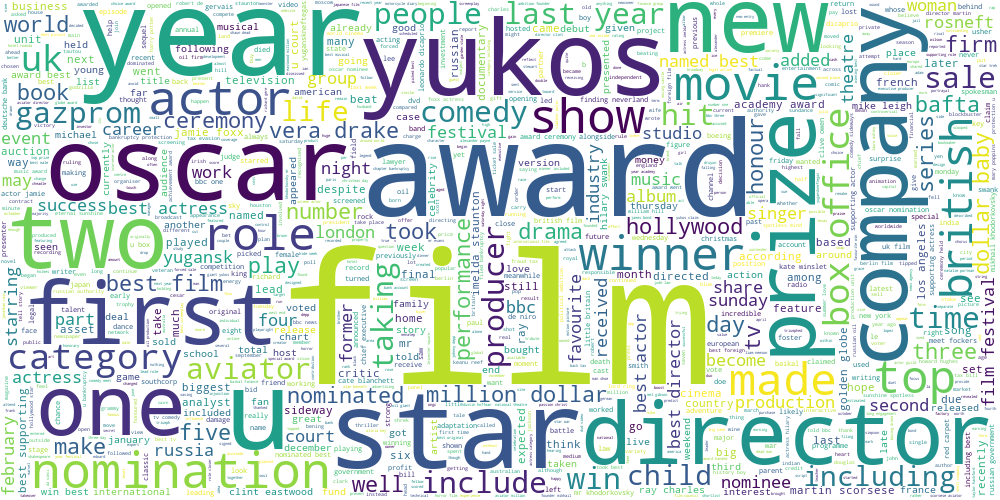

In [312]:
draw_wordcloud(data.text[labels_lda == 0])

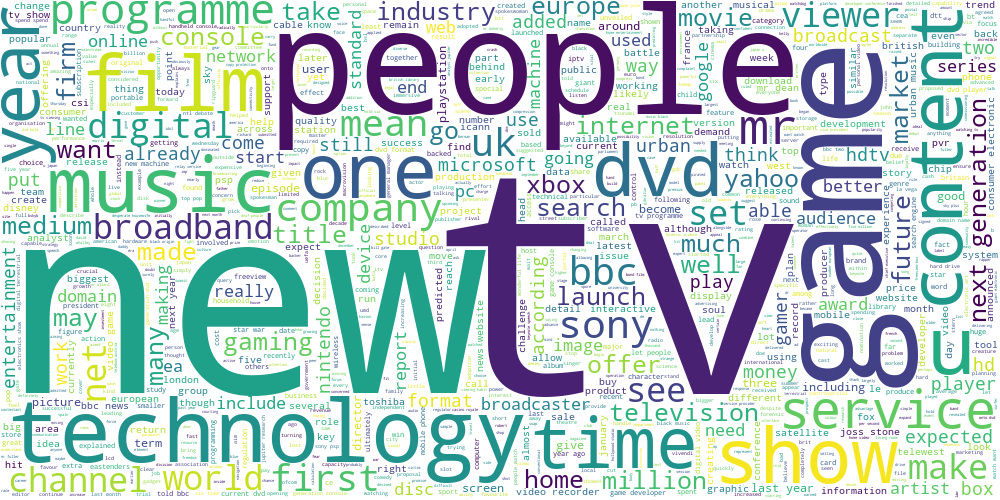

In [329]:
draw_wordcloud(data.text[labels_lda == 13])

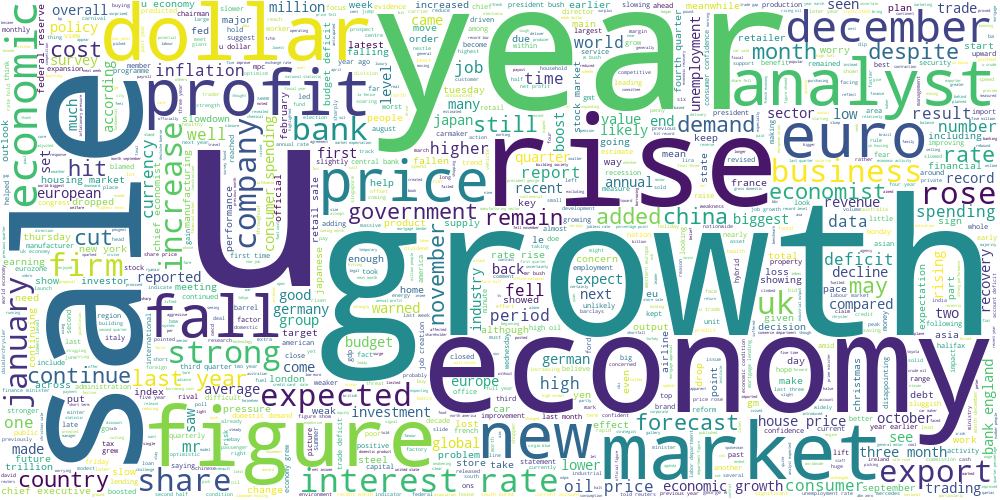

In [325]:
draw_wordcloud(data.text[labels_lda == 15])


## Часть 3. Transfer learning для задачи классификации текстов

**Задание 3.1 (0.5 балла).** Вспомним, что у нас есть разметка для тематик статей. Попробуем обучить классификатор поверх unsupervised-представлений для текстов. Рассмотрите три модели:

* Логистическая регрессия на tf-idf признаках
* K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров
* Латентное размещение Дирихле + логистическая регрессия на вероятностях тем

Разделите выборку на обучающую и тестовую, замерьте accuracy на обоих выборках для всех трех моделей. Параметры всех моделей возьмите равными значениям по умолчанию.

In [447]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

LR = 'LR         '
LR_OVER_KMEANS = 'LR over KMEANS'
LR_OVER_LDA = 'LR over LDA'

class DoubleModel:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
    
    def fit(self, X, y):
        self.model_2.fit(self.model_1.fit_transform(X), y)

    def predict(self, X):
        return self.model_2.predict(self.model_1.transform(X))

np.random.seed(997)
tf_idf_train, tf_idf_test, bow_train, bow_test, y_train, y_test =\
    train_test_split(X, bag_of_words, data.category, stratify=data.category)

models = {
    LR: LogisticRegression(),
    LR_OVER_KMEANS: DoubleModel(KMeans(), LogisticRegression()),
    LR_OVER_LDA: DoubleModel(LatentDirichletAllocation(), LogisticRegression())
}

In [448]:
for name, model in models.items():
    x_train, x_test = tf_idf_train, tf_idf_test
    if name == LR_OVER_LDA:
        x_train, x_test = bow_train, bow_test
    model.fit(x_train, y_train)
    print('Accuray for', name, '\ttrain:', accuracy_score(model.predict(x_train), y_train), 
        '\ttest:', accuracy_score(model.predict(x_test), y_test))

Accuray for LR          	train: 0.9958033573141487 	test: 0.9748653500897666
Accuray for LR over KMEANS 	train: 0.8914868105515588 	test: 0.8850987432675045
Accuray for LR over LDA 	train: 0.8105515587529976 	test: 0.9048473967684022


У какой модели получилось лучшее качество? С чем это связано?

**Ответ:** У самого обычного логрега получилось лучшее качество. Наверное, по причине схожести текстов и возможности более глубокого обучения на них, что не дают выходы KMeans и LDA.

**Задание 3.2 (1.5 балла).** Теперь просимулируем ситуацию слабой разметки, которая часто встречается в реальных данных. Разделим обучающую выборку в пропорции 5:65:30. Будем называть части, соответственно, размеченный трейн, неразмеченный трейн и валидация.

Все unsupervised-алгоритмы (векторайзеры и алгоритмы кластеризации) запускайте на всем трейне целиком (размеченном и неразмеченном, суммарно 70%), а итоговый классификатор обучайте только на размеченном трейне (5%). Подберите гиперпараметры моделей по качеству на валидации (30%), а затем оцените качество на тестовой выборке (которая осталась от прошлого задания). Не скромничайте при подборе числа кластеров, сейчас нас интересует не интерпретируемое разбиение выборки, а итоговое качество классификации. 

In [419]:
tf_idf_train_, bow_train_, y_train_ = tf_idf_train, bow_train, y_train

In [420]:
class UnsupervidedDoubleModel(DoubleModel):
    def fit(self, X_uns, X, y):
        self.model_1.fit(X_uns)
        self.model_2.fit(self.model_1.transform(X), y)

np.random.seed(113)
uns_tf_idf_train, tf_idf_val, uns_bow_train, bow_val, uns_y_train, y_val = train_test_split(
    tf_idf_train, bow_train, y_train, stratify=y_train, test_size=0.3)
sup_tf_idf_train, _, sup_bow_train, _, sup_y_train, _ = train_test_split(
    uns_tf_idf_train, uns_bow_train, uns_y_train, stratify=uns_y_train, test_size=65./70)

In [423]:
from itertools import product
model_config = {
    LR: [], # LogisticRegression()
    LR_OVER_KMEANS: [], # UnsupervidedDoubleModel(KMeans(), LogisticRegression())
    LR_OVER_LDA: [] # UnsupervidedDoubleModel(LatentDirichletAllocation(), LogisticRegression())
}
lr_c = np.logspace(-3, 3, 5)
clusters = np.linspace(5, 30, 5, dtype=int)
for name, arr in model_config.items():
    if name == LR:
        for c in lr_c:
            arr += [LogisticRegression(C=c)]
        continue

    for c, cnt in product(lr_c, clusters):
        if name == LR_OVER_KMEANS:
            arr += [UnsupervidedDoubleModel(
                KMeans(n_clusters=cnt), LogisticRegression(C=c))]
        else:
            arr += [UnsupervidedDoubleModel(
                LatentDirichletAllocation(n_components=cnt), LogisticRegression(C=c))]

In [424]:
best_models = {
    LR: {
        'score': 0,
        'model': None
    },
    LR_OVER_KMEANS: {
        'score': 0,
        'model': None
    },
    LR_OVER_LDA: {
        'score': 0,
        'model': None
    },
}

In [446]:
# 4min
np.random.seed(113)

def print_models_params(name, params):
    print('Model name:', name)
    print('\tParams:')
    if name == LR:
        print('\t\tC:', params['model'].C)
        return
    print('\t\tC:', params['model'].model_2.C)
    if name == LR_OVER_LDA:
        print('\t\tC:', params['model'].model_1.n_components)
        return
    print('\t\tC:', params['model'].model_1.n_clusters)


for name, models in model_config.items():
    sup_x_train, uns_x_train, x_val, x_test =\
        sup_tf_idf_train, uns_tf_idf_train, tf_idf_val, tf_idf_test
    if name == LR_OVER_LDA:
        sup_x_train, uns_x_train, x_val, x_test =\
            sup_bow_train, uns_bow_train, bow_val, bow_test

    for model in models:
        if name == LR:
            model.fit(sup_x_train, sup_y_train)
        else:
            model.fit(uns_x_train, sup_x_train, sup_y_train)
        val_score = accuracy_score(model.predict(x_val), y_val)
        if best_models[name]['score'] < val_score:
            best_models[name]['score'] = val_score
            best_models[name]['model'] = model
    
    params = best_models[name]
    print_models_params(name, params)
    print('\tAccuray:'
          '\n\t\ttrain:', accuracy_score(params['model'].predict(sup_x_train), sup_y_train), 
          '\n\t\tval:', params['score'],
          '\n\t\ttest:', accuracy_score(params['model'].predict(x_test), y_test))
    print()

Model name: LR         
	Params:
		C: 31.622776601683793
	Accuray:
		train: 1.0 
		val: 0.9241516966067864 
		test: 0.8994614003590664

Model name: LR over KMEANS
	Params:
		C: 1000.0
		C: 11
	Accuray:
		train: 0.963855421686747 
		val: 0.9600798403193613 
		test: 0.9497307001795332

Model name: LR over LDA
	Params:
		C: 31.622776601683793
		C: 23
	Accuray:
		train: 0.9156626506024096 
		val: 0.9101796407185628 
		test: 0.881508078994614



Как изменились результаты по сравнению с обучением на полной разметке? Сделайте выводы.

**Ответ:**
* `LR` поверх `tl-idf` естественно ослабла, однако всё равно показала не плохой результат.
* `LR` поверх `KMeans` и `LR` поверх `LDA` улучшили предсказание и перегнали или почти догнали 1 метод соотвественно. Видимо, улучшения произошли за счёт лучшего подбора гиперпараметров.

## Бонус

**Задание 4 (1 балл)**. Разберитесь с semi-supervised методами, которые реализованы в `sklearn` и примените их к заданию 3.2. Получилось ли добиться лучшего качества? Сделайте выводы.

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 5 (1 балл)**. На занятиях мы обсуждали, что метрика [BCubed](https://www.researchgate.net/profile/Julio-Gonzalo-2/publication/225548032_Amigo_E_Gonzalo_J_Artiles_J_et_alA_comparison_of_extrinsic_clustering_evaluation_metrics_based_on_formal_constraints_Inform_Retriev_12461-486/links/0c96052138dbb99740000000/Amigo-E-Gonzalo-J-Artiles-J-et-alA-comparison-of-extrinsic-clustering-evaluation-metrics-based-on-formal-constraints-Inform-Retriev-12461-486.pdf) хорошо подходит для сравнения алгоритмов кластеризации, если нам известно настоящее разделение на кластеры (gold standard). Реализуйте подсчет метрики BCubed и сравните несколько алгоритмов кластеризации на текстовых данных из основного задания. В качестве gold standard используйте разметку category.

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 6 (2 баллa)**. Спектральная кластеризация, по сути, является обычной кластеризацией KMeans поверх эмбеддингов объектов, которые получаются из лапласиана графа. А что, если мы попробуем построить эмбеддинги каким-нибудь другим способом? В этом задании мы предлагаем вам проявить немного фантазии. Возьмите какие-нибудь данные высокой размерности, чтобы задача обучения эмбеддингов имела смысл (например, картинки или тексты, желательно выбрать что-нибудь оригинальное). Придумайте или найдите какой-нибудь метод обучения эмбеддингов, примените его к данным и кластеризуйте полученные представления. Если чувствуете в себе достаточно силы, можете попробовать что-нибудь нейросетевое. Сравните ваш подход с базовыми алгоритмами кластеризации, которое мы рассмотрели в основном задании, не забывайте про визуализации! Ключевые слова для вдохновения: ***KernelPCA***, ***UMAP***, ***autoencoders***, ***gensim***. 

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 7 (1 балл)**. В нынешние непростые времена как никогда важно уметь отвлекаться и находить себе развлечение. Мы поощряем не только предметное, но и духовное развитие. Поэтому, чтобы заработать балл за этот социализационный бонус, сходите на какую-нибудь выставку или в музей, напишите небольшой отчетик о ваших впечатлениях и добавьте фотопруфы в ноутбук при сдаче. Можете объединиться с одногруппниками/однокурсниками, а также пригласить ассистентов/преподавателей, они тоже будут рады выбраться куда-нибудь. Для вдохновения приведем ссылку на актуальные выставки [новой](https://www.youtube.com/watch?v=dQw4w9WgXcQ&ab) и [старой Третьяковки](https://www.youtube.com/watch?v=xm3YgoEiEDc) (но совсем не обязательно посещать именно их).

In [ ]:
# YOUR CODE HERE (ノಠ益ಠ)ノ彡┻━┻